# QComp - Coding Session #2: Implementing the HHL algorithm.

This is the second part of a series of lab sessions to implement and analyze the HHL algorithm.

* In Coding Session #1, we implemented QPE
* In this coding session, we shall use it to code HHL in a very naïve manner

In this session:
* Parts 1, 2 and 3 are to be done during the lab session, not graded.
* Parts 4 and 5 is a homework, to be graded.

#### Deliverable

1. A **report** with your answers in a **PDF FILE** (made out of LaTeX, libreoffice, export of the notebook...)
  * Math and text answers
  * The code for the circuits
  * Screenshot of figures/circuits
  * python answers and results of runs
  * *etc*

2. **This notebook**
  * as a runnable script

First, make sure libraries are installed (you can comment those)

In [38]:
! python -m pip install matplotlib
! python -m pip install qiskit qiskit-aer


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


Now, some libraries to load (nothing to modify here)

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from math import pi, gcd
from qiskit import *
from qiskit.circuit import *
from qiskit.circuit.library import *
from qiskit.quantum_info.operators import Operator
from qiskit_aer import AerSimulator, StatevectorSimulator
from scipy import optimize
from math import *
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

Small library for pretty-printing (nothing to do)

In [40]:
def nat2bl(pad,n):
    if n == 0: r = [0 for i in range(pad)]
    elif n % 2 == 1: r = nat2bl(pad-1,(n-1)//2); r.append(1)
    else: r = nat2bl(pad-1,n//2); r.append(0)
    return r

def bl2nat(s):
    if len(s) == 0: return 0
    else: a = s.pop(); return (a + 2*bl2nat(s))

def bl2bs(l):
    if len(l) == 0: return ""
    else: a = l.pop(); return (bl2bs(l) + str(a))

def nat2bs(pad,i): return bl2bs(nat2bl(pad,i))

def bs2bl(s):
    l = []
    for i in range(len(s)): l.append(int(s[i]))
    return l

def bs2nat(s): return bl2nat(bs2bl(s))


def processOneState(st): # Length = power of 2
        s = list(st)
        if len(s) == 2: return {'0' : s[0], '1' : s[1]}
        else:
            a0 = processOneState(s[:len(s)//2])
            a1 = processOneState(s[len(s)//2:])
            r = {}
            for k in a0: r['0' + k] = a0[k]
            for k in a1: r['1' + k] = a1[k]
            return r

def printOneState(d, keys=None): # get a dict as per processStates output
    isThereMore = True
    if keys == None:
        keys = d.keys()
        isThereMore = False
    for k in sorted(keys):
        if k not in d:
            print(f"Error: {k} not valid. Maybe the size of the bitstring is invalid?")
            isThereMore = False
            break
        im = d[k].imag
        re = d[k].real
        if abs(im) >= 0.001 or abs(re) >= 0.001:
            print("% .5f + % .5fj |%s>" % (re,im,k))
    if isThereMore: print(" ... (there might be more hidden terms)")

def printFinalRes(result, keys=None):
    printOneState(processOneState(list(np.asarray(result))), keys)

def runStateVector(qc, keys=None):
    simulator = StatevectorSimulator(statevector_parallel_threshold=6)
    job = simulator.run(qc.decompose(reps=6), memory=True)
    job_result = job.result()
    result = job_result.results[0].to_dict()['data']['statevector']
    if keys is not None:
        # Créer un dictionnaire avec la partie réelle pour chaque clé
        reals = {k: result[int(k, 2)].real for k in keys}
        return reals
    else:
        printFinalRes(result, keys)

def runStateVectorSeveralTimes(qc, howmany):
    qc.save_statevector(label = 'collect', pershot = True)
    simulator = StatevectorSimulator()
    job = simulator.run(qc.decompose(reps=6), memory=True, shots=howmany)
    result = job.result()
    memory = result.data(0)['memory']
    collect = result.data(0)['collect']
    r = {}
    for i in range(len(collect)):
        r[str(collect[i])] = (0, collect[i])
    for i in range(len(collect)):
        n, v = r[str(collect[i])]
        r[str(collect[i])] = (n+1, v)
    for k in r:
        i, v = r[k]
        print(f"With {i} occurences:")
        printFinalRes(v)

def plotDistrib(d):
    sorted_items = sorted(d.items())
    keys = [k for k, _ in sorted_items]
    values = [v for _, v in sorted_items]
    plt.figure()
    plt.bar(keys, values)
    plt.xticks(rotation=90)
    plt.show()

def getSample(qc,howmany):
    simulator = AerSimulator()
    job = simulator.run(qc.decompose(reps=6), shots=howmany)
    res = dict(job.result().get_counts(qc))
    return res

def plotSample(qc,howmany):
    d = getSample(qc,howmany)
    ld = len(list(d.keys())[0])
    for i in range(2 ** ld):
        s = nat2bs(ld,i)
        if s not in d: d[s] = 0
    plotDistrib(d)

# 0 - Some Background

## 0.1 - Computing (and Showing) State Vectors

Let us use QisKit to compute a state vector, directly, with the backend `StatevectorSimulator`.

In [41]:
q1 = QuantumRegister(3, name="q1")
q2 = QuantumRegister(1, name="q2")
qc = QuantumCircuit(q1,q2)

qc.x(q1[0])
qc.h(q1[1])
qc.h(q2[0])

qc.cx(q2[0],q1[2])

# Show circuit, just to check
qc.draw()

┌───┐     
q1_0: ┤ X ├─────
      ├───┤     
q1_1: ┤ H ├─────
      └───┘┌───┐
q1_2: ─────┤ X ├
      ┌───┐└─┬─┘
  q2: ┤ H ├──■──
      └───┘

We can now "run" the circuit and see what is the state vector at the end. As we saw in the previous lab session, I wrote a small wrapper function to "nicely" print out the result. The precision is caped at 10${}^{-5}$ for readability.

In [42]:
runStateVector(qc)

 0.50000 +  0.00000j |0001>
 0.50000 +  0.00000j |0011>
 0.50000 +  0.00000j |1101>
 0.50000 +  0.00000j |1111>


Note how `q2` (that was put at the end in `QuantumRegister`) appears at the beginning in the ket basis vectors. Compared to the circuit drawing, one must "turn the head to the left". I tried to use the same conventions as the results of measurements.

It is possible to only show some of the basis vectors (when the sum is large and we only care about a handful of them).

In [43]:
runStateVector(qc, keys=["0011", "1111"])

{'0011': np.float64(0.5), '1111': np.float64(0.4999999999999999)}

## 0.2 - The HHL Algorithm

For the presentation of the algorithm, see Section 3.6 of the lecture notes. In this section, we summarize the notations. The inputs to the algorithm is a hermitian matrix $A$ and a vector $\vec{b}$, and the problem is to solve the system

$$A\cdot \vec{x} = \vec{b}$$

The idea consists in coding the vectors $\vec{b}$ and $\vec{x}$ in the state of registers: if $\vec{b} = (b_0,b_1,b_2,b_3)$, we store the vector in $|b\rangle = b_0\cdot|00\rangle+b_1\cdot|01\rangle+b_2\cdot|10\rangle+b_3\cdot|11\rangle$, modulo some renormalization.




Of course, there are some constraints. But in summary, if
* $N$ is the size of the system
* $s$ is the number of non-zero elements on each line of $A$
* $κ$ is the matrix condition number (the ratio between the largest and the smallest eigenvalue)
* $ϵ$ is the allowed error

The the complexities are

* $\mathcal{O}(Nsκ\log(1/ϵ))$ for the classical algorithm

* $\mathcal{O}(\log(N)s^2κ^2/ϵ)$ for HHL

Meaning that, in theory, we get an speedup exponential on the size of the system.

# 1 - Case Study for this Lab Session

We are going to use the case study described in Section 6.3.13 of the lecture notes. The system is

$$\begin{align}
x_1-\frac{x_2}3 &= 1\\
\frac{-x_1}3 + x_2 &= 0
\end{align}
$$

## 1.1 - Memory Encoding

A single qubit is enough to store $\vec{b}$ and $\vec{x}$:

$$\begin{align}
\vec{b} &\quad\equiv\quad 1\cdot|0\rangle + 0\cdot|1\rangle\\
\vec{x} &\quad\equiv\quad (D\,x_1)\cdot|0\rangle + (D\,x_2)\cdot|1\rangle
\end{align}$$

where $D$ is a renormalization factor. Indeed, if you remember the lecture notes, the solution is

$$\left(\begin{array}{c}9/8\\3/8\end{array}\right)$$

which is not of norm $1$.


## 1.2 - Coding the algorithm

The algorithm relies on several quantum registers:

* `qb`: to store $\vec{b}$ and to read $\vec{x}$. Here, of size $1$.
* `qe`: ancilla to store the eigenvalues. For the given example, $2$ qubits are enough.
* `qi`: a single qubit, to characterize the "good" subspace (where we can read the result).


We need several subroutines for the algorithm:

1. Initialization of the input vector $\vec{b}$: In our case it is trivial.

2. QPE : this has been done in Lab Session #1.

3. The unitary to use for QPE: built from $A$, it is  $U = e^{iAt}$, for a "correct" $t$, depending on $\kappa$: it should be small enough so that the eigenvalues of $tA$ do not "overflow", yet large enough to be readable.

4. A subroutine implementing the inversion oracle.

The major difficulty lies in the last two points. In this lab session, we shall use a quick-n-dirty road to get a working example (albeit not scalable).

## 1.3 - The matrix $A$ and the operator $U$

For our algorithm, we shall need the exponential $U = e^{iAt}$. In general, when $A$ is very large, computing $U$ is a costly operation: in the context of quantum computation, a strategy consists in using e.g. Trotterization, subject of the next lecture.

For the purpose of our small $2\times 2$ case-study, we shall simply compute the matrix $U$ using the function `expm` of the library `linalg` and the built-in generic circuit synthesis implemented in QisKit.

In [44]:
# The matrix A 

A = np.array([[1,-1/3],[-1/3,1]])
A

array([[ 1.        , -0.33333333],
       [-0.33333333,  1.        ]])

In [45]:
# The coefficient giving exact results

t = 2*pi*3/8

# The exponential of $A$

EA = linalg.expm((1j)*t*A)
EA

array([[-0.5+0.5j,  0.5+0.5j],
       [ 0.5+0.5j, -0.5+0.5j]])

In [46]:
# The corresponding unitary gate, using QisKit magic

U = UnitaryGate(Operator(EA))
U

Instruction(name='unitary', num_qubits=1, num_clbits=0, params=[array([[-0.5+0.5j,  0.5+0.5j],
       [ 0.5+0.5j, -0.5+0.5j]])])

## 1.4 - The inversion subroutine

Assume for simplicity that the eigenvalues are non-negative.
We want to invert a value $\lambda\gt 0$ coded on 2 bits, for instance as follows:

$$\lambda = \frac{e_0}{2} + \frac{e_1}{4}$$

(with $e_0$ and $e_1$ Boolean values).

Note that $\frac13\leq \frac1{4\lambda} \leq 1$

We now want an operator that produces

$$|e_1e_0\rangle\otimes|0\rangle\mapsto |e_1e_0\rangle\otimes\left(\sqrt{1 - \frac1{16\lambda^2}}|0\rangle + \frac1{4\lambda}|{1}\rangle\right)$$

Here, the value $\frac14$ is the coefficient $C$ in Section 6.3.13 of the lecture notes. It is chosen so that the coefficients of shape $\frac{2\pi\cdot C}{\lambda t}$ obtained from the eigenvalues of $tA$ are indeed within $-1$ and $1$.


#### TODO

Realize this operation with multi-controlled $R_y(\theta)$ gates. The gate is

$$
R_y(\theta)
=
\left(
\begin{array}{cc}
\cos(\theta/2) & -\sin(\theta/2)\\
\sin(\theta/2) & \cos(\theta/2)
\end{array}
\right)
$$

To build the circuit:
* Arcsine is `np.arcsin` in Python
* $R_y$ gates are `RYGate(angle)` in QisKit
* A gate `gate` can be controlled with `gate.control(num_ctrl_qubits=3, ctrl_state='101')` if you want 3 controls: 1 negative, 1 positive, 1 negative
* A gate can be inserted in a circuit with`mycircuit.append(mygate, list-of-wires)`.

In [47]:
# For the value to invert, start with a 2-qubit register
n = 2
q = QuantumRegister(n, name="q")

# To store the invert
r = QuantumRegister(1, name="r")

qcinv = QuantumCircuit(q,r)

C = 1 / 4 
for  i in range(1, 2**n):
    ry_gate = RYGate(2 * np.arcsin(C * 4 / i))
    bin_string = nat2bs(n, i)
    controlled_ry = ry_gate.control(num_ctrl_qubits=n, ctrl_state=bin_string)
    qcinv.append(controlled_ry,  list(q) + [r[0]])



qcinv.draw()

q_0: ────■─────────o────────────■───────
         │         │            │       
q_1: ────o─────────■────────────■───────
     ┌───┴───┐┌────┴────┐┌──────┴──────┐
  r: ┤ Ry(π) ├┤ Ry(π/3) ├┤ Ry(0.67967) ├
     └───────┘└─────────┘└─────────────┘

We will now store this circuit inside a (large) unitary gate `invCirc` acting on 3 wires.

In [48]:
invCirc = qcinv.to_gate(label="inv")

To understand how to use this gate (and make sure it works), here is a small code snippet. Change the value `v` to check that you get the correct value.

* The gate `invCirc` is added to a circuit with `qc.append(invCirc, list-of-wires)`
* Where do we read the value $1/v$ ?
* At the level of kets, where are the registers `q` and `r`?

In [49]:
# The value to invert : test 1, 2 and 3 and make sure to understand what's going on
v = 3

# For the value to invert
q = QuantumRegister(n, name="q")

# To store the value
r = QuantumRegister(1, name="r")

qctest = QuantumCircuit(q,r)
bi = list(reversed(nat2bl(n,v)))  
for i in range(len(bi)):
    if bi[i] == 1:
        qctest.x(q[i])

qctest.append(invCirc, list(q) + [r[0]])
# qctest.draw()
#Execute and get result
runStateVector(qctest)

 0.94281 + -0.00000j |011>
 0.33333 + -0.00000j |111>


Quand le premier qubit à 1 un, cela veut dire que l'inversion est réussie. |1**> c'est là qu'on lit l'inversion, sur la partie réelle du coefficient.

# 3 - Summing-up: Complete HHL Algorithm

Below you will find a code with holes to be filled in, realizing HHL with 2 bits of precisions, using the pieces above and QPE that was done in Lab Session #2.

#### 3.1 - TODO

Fill in the holes in order to get a circuit with the right shape and that computes the correct answer.

In [50]:
# For |b>
nb = 1
qb = QuantumRegister(nb, name="b")

# For the eigenvalue : ne bits of précision
ne = 2
qe = QuantumRegister(ne, name="eig")

# For the angle : only one qubit
qi = QuantumRegister(1, name="inv")

# Creating the circuit
qc = QuantumCircuit(qi,qe,qb)

## TODO : QPE on qb and qe
qc.h(qe)

for i in range(ne):

    qc.append(U.power(2 ** i).control(1), [qe[i]] + qb[:])

qc.append(QFTGate(ne).inverse(), qe)

## TODO invCirc on qe and qi
qc.append(invCirc, list(qe) + list(qi))

## TODO : QPE, inverted
qc.append(QFTGate(ne), qe)
for i in reversed(range(ne)):
    qc.append(U.inverse().power(2 ** i).control(1), [qe[i]] + qb[:])
qc.h(qe)


# Beware ! We do not measure because we want to see the final state vector.
# Let us draw the circuit and check that it looks correct
qc.draw()

┌──────┐                     »
  inv: ──────────────────────────────────────────┤2     ├─────────────────────»
       ┌───┐                          ┌─────────┐│      │┌──────┐             »
eig_0: ┤ H ├──────■───────────────────┤0        ├┤0 inv ├┤0     ├─────────────»
       ├───┤      │                   │  qft_dg ││      ││  Qft │             »
eig_1: ┤ H ├──────┼────────────■──────┤1        ├┤1     ├┤1     ├──────■──────»
       └───┘┌─────┴─────┐┌─────┴─────┐└─────────┘└──────┘└──────┘┌─────┴─────┐»
    b: ─────┤ unitary^1 ├┤ unitary^2 ├───────────────────────────┤ unitary^2 ├»
            └───────────┘└───────────┘                           └───────────┘»
«                         
«  inv: ──────────────────
«                    ┌───┐
«eig_0: ──────■──────┤ H ├
«             │      ├───┤
«eig_1: ──────┼──────┤ H ├
«       ┌─────┴─────┐└───┘
«    b: ┤ unitary^1 ├─────
«       └───────────┘

Now, let us test the circuit.

In [51]:
# Run the circuit
runStateVector(qc)

 0.43301 +  0.00000j |0000>
 0.75000 +  0.00000j |0001>
-0.43301 + -0.00000j |1000>
 0.25000 +  0.00000j |1001>


Quand le dernier qbit est 1 c'est que l'inversion est réalisée. Les deux qbits du milieu sont à zéro puisque j'ai appliqué QFE et QFE inverse. Le premier qbit correspond à la valeur de x. On obtient 0.25 et 0.75. 

Remember (or look at Section 6.3.10 Point 4 in the lecture notes) that the final state should be

$$|0\rangle_{qi}\otimes[\text{uninteresting}]
+
\frac{2\pi C}{t}|1\rangle_{qi}\otimes|x\rangle $$

#### 3.2 - TODO

* In our very constrained example, what should be the solution for the interesting part of the vector? (and why?)
* Make sure that you indeed get it! We made sure to pick a case study with exact values, so it should work without error.
* Ping your teaching assistant if you do not understand something.

# 4 - HOMEWORK - Influence of parameters.

So far, we chose 2 bits of precision: It is arguably a bit short to
"solve" another system. Let us play with the size of `qe` and the
values `C` and `t`.

The bottom line to remember is:
* `t` makes the eigenvalues of $tA$ fit below $1$
* `C` ensures that the coefficient of the "interesting" part of the result is high enough, yet valid.

Do not change your code since it is working: instead, make new cells!
If you want a compact code, you can of course package things in functions.

#### 4.1 - TODO

In the following cell, update your code so that `qe` is now 5 qubit-long.
 * The main modification lies in the inversion operator
 * Do not change C: Instead, only use controlled-Ry with for which arcsine is well-defined.
 * You should see the same result as before, modulo the number of `0`'s in the register `qe`

In [52]:
n = 5 # modifié

q = QuantumRegister(n, name="q")
r = QuantumRegister(1, name="r")
qcinv = QuantumCircuit(q,r)

C = 1 / 4 



for  i in range(1, 2**n):
    angle = C * 2**n / i
    if -1 <= angle <= 1: # modifié
        ry_gate = RYGate(2 * np.arcsin(angle))
        bin_string = nat2bs(n, i)
        controlled_ry = ry_gate.control(num_ctrl_qubits=n, ctrl_state=bin_string)
        qcinv.append(controlled_ry,  list(q) + [r[0]])

qcinv.draw()
invCirc = qcinv.to_gate(label="inv")




# For |b>
nb = 1
qb = QuantumRegister(nb, name="b")

# For the eigenvalue : ne bits of précision
ne = 5 # modifié
qe = QuantumRegister(ne, name="eig")

# For the angle : only one qubit
qi = QuantumRegister(1, name="inv")

# Creating the circuit
qc = QuantumCircuit(qi,qe,qb)

## TODO : QPE on qb and qe
qc.h(qe)

for i in range(ne):

    qc.append(U.power(2 ** i).control(1), [qe[i]] + qb[:])

qc.append(QFTGate(ne).inverse(), qe)

## TODO invCirc on qe and qi
qc.append(invCirc, list(qe) + list(qi))

## TODO : QPE, inverted
qc.append(QFTGate(ne), qe)
for i in reversed(range(ne)):
    qc.append(U.inverse().power(2 ** i).control(1), [qe[i]] + qb[:])
qc.h(qe)


# Beware ! We do not measure because we want to see the final state vector.
# Let us draw the circuit and check that it looks correct
# qc.draw()

runStateVector(qc)

 0.43301 +  0.00000j |0000000>
 0.75000 + -0.00000j |0000001>
-0.43301 +  0.00000j |1000000>
 0.25000 + -0.00000j |1000001>


#### 4.2 - TODO

Now, move C from $1/4$ to $1/8$, and re-run the code
 * What should be the coefficients of the final state?
 * Do you indeed get them?
 * Divide `t` by $2$: change it to $3\cdot\pi/8$. Can you explain what you see?
 * Change `t` for $2\pi\cdot3.2/16$ (the value $3$ is now slightly off: $3.2$). How has the quality changed? Why? Where do we "read" the result?

In [ ]:
n = 5# modifié


A = np.array([[1,-1/3],[-1/3,1]]) 
# The coefficient giving exact results

# t = pi*3/8 # modifié
# t = 2*pi*3/8 # modifié
t = 2*pi*3.2/16 # modifié

# C = 1 / 8 # modifié
C = 1 / 2**n # modifié


solution = np.linalg.solve(A, np.array([1,0]))
print("Classical solution:")
print(solution)
coefficient = 2 * pi * solution * C / t
print("Expected coefficients in the quantum solution (up to normalization):")
print(coefficient)


# The exponential of $A$
EA = linalg.expm((1j)*t*A)
U = UnitaryGate(Operator(EA))
q = QuantumRegister(n, name="q")
r = QuantumRegister(1, name="r")
qcinv = QuantumCircuit(q,r)


for  i in range(1, 2**n):
    angle = C * 2**n / i
    if -1 <= angle <= 1: # modifié
        ry_gate = RYGate(2 * np.arcsin(angle))
        bin_string = nat2bs(n, i)
        controlled_ry = ry_gate.control(num_ctrl_qubits=n, ctrl_state=bin_string)
        qcinv.append(controlled_ry,  list(q) + [r[0]])

qcinv.draw()
invCirc = qcinv.to_gate(label="inv")




# For |b>
nb = 1
qb = QuantumRegister(nb, name="b")

# For the eigenvalue : ne bits of précision
ne = n # modifié
qe = QuantumRegister(ne, name="eig")

# For the angle : only one qubit
qi = QuantumRegister(1, name="inv")

# Creating the circuit
qc = QuantumCircuit(qi,qe,qb)

## QPE on qb and qe
qc.h(qe)

for i in range(ne):

    qc.append(U.power(2 ** i).control(1), [qe[i]] + qb[:])

qc.append(QFTGate(ne).inverse(), qe)

## invCirc on qe and qi
qc.append(invCirc, list(qe) + list(qi))

## QPE, inverted
qc.append(QFTGate(ne), qe)
for i in reversed(range(ne)):
    qc.append(U.inverse().power(2 ** i).control(1), [qe[i]] + qb[:])
qc.h(qe)


sv = runStateVector(qc, keys=["0"+ n*"0"+"1", "1"+ n*"0"+"1"])
reals = {k: v.real for k, v in sv.items()}

print("Results of quantum computation:")
print(reals)


Classical solution:
[1.125 0.375]
Expected coefficients in the quantum solution (up to normalization):
[0.17578125 0.05859375]
Results of quantum computation:
{'0000001': np.float64(0.18343743853666916), '1000001': np.float64(0.06302704066450893)}


#### 4.3 - TODO

Set `t` back to $2\pi\cdot3/16$. In `A`, replace $-1/3$ with $-1/2$.
 * What should now be the answer?
 * Can you confirm that the code is producing a correct approximation?
 * (you should still get only 4 terms in superposition!)
 * (we reduced the value of `t` because the eigenvalues of `A` would have been too large for arcsine)

In [ ]:
n = 5 # modifié


A = np.array([[1,-1/2],[-1/2,1]]) # modifié
# The coefficient giving exact results

C = 1 / 8# modifié
C = 1 / 2**n # modifié
# t = 2*pi*3/16 # modifié
t = pi*3/16# modifié


solution = np.linalg.solve(A, np.array([1,0]))
print("Classical solution:")
print(solution)
coefficient = 2 * pi * solution * C / t
print("Expected coefficients in the quantum solution (up to normalization):")
print(coefficient)


# The exponential of $A$

EA = linalg.expm((1j)*t*A)
U = UnitaryGate(Operator(EA))

q = QuantumRegister(n, name="q")
r = QuantumRegister(1, name="r")
qcinv = QuantumCircuit(q,r)




for  i in range(1, 2**n):
    angle = C * 2**n / i
    if -1 <= angle <= 1: # modifié
        ry_gate = RYGate(2 * np.arcsin(angle))
        bin_string = nat2bs(n, i)
        controlled_ry = ry_gate.control(num_ctrl_qubits=n, ctrl_state=bin_string)
        qcinv.append(controlled_ry,  list(q) + [r[0]])

qcinv.draw()
invCirc = qcinv.to_gate(label="inv")




# For |b>
nb = 1
qb = QuantumRegister(nb, name="b")

# For the eigenvalue : ne bits of précision
ne = n # modifié
qe = QuantumRegister(ne, name="eig")

# For the angle : only one qubit
qi = QuantumRegister(1, name="inv")

# Creating the circuit
qc = QuantumCircuit(qi,qe,qb)

## QPE on qb and qe
qc.h(qe)

for i in range(ne):

    qc.append(U.power(2 ** i).control(1), [qe[i]] + qb[:])

qc.append(QFTGate(ne).inverse(), qe)

## invCirc on qe and qi
qc.append(invCirc, list(qe) + list(qi))

## QPE, inverted
qc.append(QFTGate(ne), qe)
for i in reversed(range(ne)):
    qc.append(U.inverse().power(2 ** i).control(1), [qe[i]] + qb[:])
qc.h(qe)


sv = runStateVector(qc, keys=["0"+ n*"0"+"1", "1"+ n*"0"+"1"])
reals = {k: v.real for k, v in sv.items()}

print("Results of quantum computation:")
print(reals)








Classical solution:
[1.33333333 0.66666667]
Expected coefficients in the quantum solution (up to normalization):
[0.44444444 0.22222222]
Results of quantum computation:
{'0000001': np.float64(0.4310947055251078), '1000001': np.float64(0.20286449447181015)}


#### 4.4 - TODO

Now, in `A`, instead of $-1/2$, use $-0.47$
 * You can find the solution to the linear system with `np.linalg.solve(A, np.array([1,0]))`.
 * Can you "read" the result in the state vector?
 * What is the error?
 * How can you make the error smaller? Give a convincing argument as of why it works.

Note: `runStateVector(qc, keys=["00001","10001"])` will filter the results of the output and only print those for $|00001\rangle$ and $|10001\rangle$. You can adjust `keys` to fit you needs.

In [18]:
n = 5 # modifié


A = np.array([[1,-0.47],[-0.47,1]]) # modifié



t = 2*pi*3/16 # modifié
# t = 2*pi/1.3 # modifié
# C = 1 / 8# modifié
C = 1 / 2**n # modifié

solution = np.linalg.solve(A, np.array([1,0]))
print("Classical solution:")
print(solution)
coefficient = 2 * pi * solution * C / t
print("Expected coefficients in the quantum solution (up to normalization):")
print(coefficient)
# The exponential of $A$

EA = linalg.expm((1j)*t*A)
U = UnitaryGate(Operator(EA))

q = QuantumRegister(n, name="q")
r = QuantumRegister(1, name="r")
qcinv = QuantumCircuit(q,r)




for  i in range(1, 2**n):
    angle = C * 2**n / i
    if -1 <= angle <= 1: # modifié
        ry_gate = RYGate(2 * np.arcsin(angle))
        bin_string = nat2bs(n, i)
        controlled_ry = ry_gate.control(num_ctrl_qubits=n, ctrl_state=bin_string)
        qcinv.append(controlled_ry,  list(q) + [r[0]])

invCirc = qcinv.to_gate(label="inv")




# For |b>
nb = 1
qb = QuantumRegister(nb, name="b")

# For the eigenvalue : ne bits of précision
ne = n # modifié
qe = QuantumRegister(ne, name="eig")

# For the angle : only one qubit
qi = QuantumRegister(1, name="inv")

# Creating the circuit
qc = QuantumCircuit(qi,qe,qb)

## QPE on qb and qe
qc.h(qe)

for i in range(ne):

    qc.append(U.power(2 ** i).control(1), [qe[i]] + qb[:])

qc.append(QFTGate(ne).inverse(), qe)

## invCirc on qe and qi
qc.append(invCirc, list(qe) + list(qi))

## QPE, inverted
qc.append(QFTGate(ne), qe)
for i in reversed(range(ne)):
    qc.append(U.inverse().power(2 ** i).control(1), [qe[i]] + qb[:])
qc.h(qe)


# Beware ! We do not measure because we want to see the final state vector.
# Let us draw the circuit and check that it looks correct
# qc.draw()
# runStateVector(qc)
sv = runStateVector(qc, keys=["0000001", "1000001"])
reals = {k: v.real for k, v in sv.items()}
print(reals)
list_coeff = np.array(list(reals.values()))
print(list_coeff)
error = np.linalg.norm(coefficient - list_coeff)
print("L'erreur est :")
print(error)






Classical solution:
[1.28353228 0.60326017]
Expected coefficients in the quantum solution (up to normalization):
[0.21392205 0.10054336]
{'0000001': np.float64(0.22149517999840923), '1000001': np.float64(0.10892913931104947)}
[0.22149518 0.10892914]
L'erreur est :
0.011299274643841554


In [19]:
def HHL_error(A, t, C, n):
    solution = np.linalg.solve(A, np.array([1,0]))
    coefficient = 2 * pi * solution * C / t
    EA = linalg.expm((1j)*t*A)
    U = UnitaryGate(Operator(EA))

    q = QuantumRegister(n, name="q")
    r = QuantumRegister(1, name="r")
    qcinv = QuantumCircuit(q,r)




    for  i in range(1, 2**n):
        angle = C * 2**n / i
        if -1 <= angle <= 1: # modifié
            ry_gate = RYGate(2 * np.arcsin(angle))
            bin_string = nat2bs(n, i)
            controlled_ry = ry_gate.control(num_ctrl_qubits=n, ctrl_state=bin_string)
            qcinv.append(controlled_ry,  list(q) + [r[0]])

    invCirc = qcinv.to_gate(label="inv")
    # For |b>
    nb = 1
    qb = QuantumRegister(nb, name="b")

    # For the eigenvalue : ne bits of précision
    ne = n # modifié
    qe = QuantumRegister(ne, name="eig")

    # For the angle : only one qubit
    qi = QuantumRegister(1, name="inv")

    # Creating the circuit
    qc = QuantumCircuit(qi,qe,qb)

    ## QPE on qb and qe
    qc.h(qe)

    for i in range(ne):

        qc.append(U.power(2 ** i).control(1), [qe[i]] + qb[:])

    qc.append(QFTGate(ne).inverse(), qe)

    ## invCirc on qe and qi
    qc.append(invCirc, list(qe) + list(qi))

    ## QPE, inverted
    qc.append(QFTGate(ne), qe)
    for i in reversed(range(ne)):
        qc.append(U.inverse().power(2 ** i).control(1), [qe[i]] + qb[:])
    qc.h(qe)
    sv = runStateVector(qc, keys=["0"+ n*"0"+"1", "1"+ n*"0"+"1"])
    reals = {k: v.real for k, v in sv.items()}
    list_coeff = np.array(list(reals.values()))
    error = np.linalg.norm(coefficient - list_coeff)
    return error



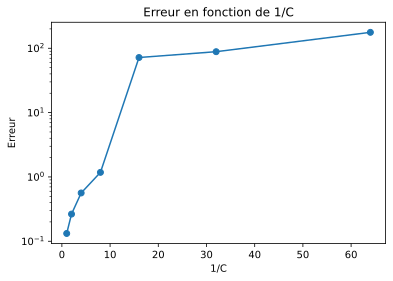

In [ ]:
n = 7
A = np.array([[1,-0.47],[-0.47,1]]) 
t = 2*pi*3/16 
error = np.zeros(n)
C_values = np.zeros(n)
for i in range(n):
    C = 1/2**i
    C_values[i] = C
    error[i] = HHL_error(A, t, C, 5)


inv_C = 1 / C_values  # 1/C pour l'axe x
inv_error = 1 / error
plt.figure(figsize=(6,4))
plt.semilogy(inv_C, inv_error, marker='o', linestyle='-')
plt.xlabel("1/C")
plt.ylabel("Erreur")
plt.title("Erreur en fonction de 1/C")
plt.grid(True, ls="--")
plt.show()

/tmp/ipykernel_53104/201197382.py:13: RuntimeWarning: divide by zero encountered in divide
  inv_error = 1 / error


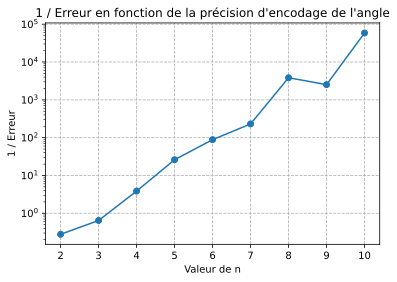

In [23]:
n_max = 10
A = np.array([[1,-0.47],[-0.47,1]]) 
t = 2*pi*3/16 
error = np.zeros(n_max)
n_values = np.arange(1, n_max + 1)  


for i in range(1, n_max):
    C = 1/2**i
    error[i] = HHL_error(A, t, C, i)


inv_error = 1 / error
plt.figure(figsize=(6,4))
plt.semilogy(n_values, inv_error, marker='o', linestyle='-')
plt.xlabel("Valeur de n")
plt.ylabel('1 / Erreur')
plt.title("1 / Erreur en fonction de la précision d'encodage de l'angle")
plt.grid(True, ls="--")
plt.show()


# 5 - HOMEWORK - Handling more general matrices

Consider $A$ and $\vec{b}$ defined as follows:
$$
A = 
\left(
\begin{array}{cc}
0 & 1\\
1 & 0
\end{array}
\right),
\qquad
\vec{b} = \frac{1}{\sqrt2}\left(
\begin{array}{cc}
1 \\ -1
\end{array}
\right).
$$

Then

$$
A \vec{b} = -\vec{b}
$$

meaning that $\vec{b}$ is an eigenvector of $A$ with eigenvalue
$-1$. The solution to $A\cdot\vec{x} = \vec{b}$ is then the vector

$$
\vec{x} = -\vec{b} = 
\frac1{\sqrt2}\left(
\begin{array}{cc}
-1 \\ 1
\end{array}
\right).
$$

The code that you wrote so far cannot handle this simple case since
the inversion operator was written by assuming that all eigenvalues
are non-negative. The problem comes from the operation "modulo $2\pi$"
that happens in $e^{i2\pi \lambda}$: if, say, $\lambda=-\frac14$, then this is

$$
e^{i2\pi \lambda} = e^{i2\pi\frac{-1}4} = e^{i2\pi\frac34}
$$

The HHL code above would take the value $\frac34\in[0,1)$ (the angle
is taken between $0$ and $2\pi$), whereas we would instead has to
consider $\frac{-1}4\in[\frac{-1}2,\frac12)$ (with an angle considered
instead between $-\pi$ and $\pi$).

We will here update the code to handle this general case.

## 5.1 - TODO - Update the inversion operator

The change should be as follows:
* Before, a basis ket vector $|e_n\cdots e_1\rangle$ was representing a fraction between $\frac0{2^n}$ and $\frac{2^n-1}{2^n}$
* Now, it should represent a represent a fraction between $-\frac{2^{n-1}}{2^n}$ (also known as $-\frac12)$ and $\frac{2^{n-1}-1}{2^n}$ (also known as $\frac12-\frac1{2^n})$

The new operator should therefore
* do as before for all values in $[0,\frac12)$
* shift any value $v\in[\frac12,1)$ to $v-1$, in the range $[-\frac12,0)$.

In [55]:
def invOpGeneral(n,C):
    q = QuantumRegister(n, name="q")
    r = QuantumRegister(1, name="r")
    qcinv = QuantumCircuit(q,r)

    for  i in range(1, 2**n):
        if i <= 2**(n - 1):
            i_angle = i
        else:
            i_angle = i - 2**n
        angle = C * 2**n / i_angle
        if -1 <= angle <= 1: #
            ry_gate = RYGate(2 * np.arcsin(angle))
            bin_string = nat2bs(n, i)
            controlled_ry = ry_gate.control(num_ctrl_qubits=n, ctrl_state=bin_string)
            qcinv.append(controlled_ry,  list(q) + [r[0]])
            
    return qcinv.to_gate(label="inv")


Testing cell: if your function `invOpGeneral` is working, the produced statevector should have
* $\frac1v$ whenever $v\in[1,16]$
* $\frac1{v-32}$ whenever $v\in[17,31]$

So $v=2$ should yield $\frac12$, $v=3$ should yield $\frac13$, and $v=30$ should yield $-\frac12$ and $v=29$ yield $-\frac13$. And $v=16$ should yield something close to $0$.

In [56]:
# The value to invert, will be coded on 5 bits: test 1, 2, 3, 4, 8, 24, 29, 30, 31
v = 29

# For the value to invert : use 5 qubits
q = QuantumRegister(5, name="q")

# To store the value
r = QuantumRegister(1, name="r")

qctest = QuantumCircuit(q,r)
bi = list(reversed(nat2bl(5,v)))
for i in range(len(bi)):
    if bi[i] == 1:
        qctest.x(q[i])

qctest.append(invOpGeneral(5,1/(2**5)), list(q) + [r[0]])

#Execute and get result
runStateVector(qctest)



 0.94281 + -0.00000j |011101>
-0.33333 +  0.00000j |111101>


## 5.2 - TODO - Update HHL

Updating HHL should be just a matter of replacing the old inversion operator with the new one.

One can then test it with
$$
A = 
\left(
\begin{array}{cc}
0 & 1\\
1 & 0
\end{array}
\right),
\qquad
\vec{b} = \frac{1}{\sqrt2}\left(
\begin{array}{cc}
1 \\ -1
\end{array}
\right).
$$
and $C=1/8$ and $t=2\pi/8$. Set the size of `qe` to $5$. The scaling factor is $1$: one should get an exact result.

Do not forget to set the register `qb` to the correct state!

In [22]:
n = 5


A = np.array([[0,1],[1,0]]) 
b = np.array([1/sqrt(2), -1/sqrt(2)])
t = 2*pi/8 
C = 1 / 8


solution = np.linalg.solve(A, b)
print("Classical solution:")
print(solution)
coefficient = 2 * pi * solution * C / t
print("Expected coefficients in the quantum solution (up to normalization):")
print(coefficient)


# The exponential of $A$
EA = linalg.expm((1j)*t*A)
U = UnitaryGate(Operator(EA))

q = QuantumRegister(n, name="q")
r = QuantumRegister(1, name="r")
qc = QuantumCircuit(q,r)








# For |b>
nb = 1
qb = QuantumRegister(nb, name="b")

# For the eigenvalue : n bits of précision
qe = QuantumRegister(n, name="eig")

# For the angle : only one qubit
qi = QuantumRegister(1, name="inv")

# Creating the circuit
qc = QuantumCircuit(qi,qe,qb)

# Creating b
qc.x(qb)
qc.h(qb)


## QPE on qb and qe
qc.h(qe)

for i in range(n):
    qc.append(U.power(2 ** i).control(1), [qe[i]] + qb[:])

qc.append(QFTGate(n).inverse(), qe)

## invCirc on qe and qi
qc.append(invOpGeneral(n, C), list(qe) + list(qi))

## QPE, inverted
qc.append(QFTGate(n), qe)
for i in reversed(range(n)):
    qc.append(U.inverse().power(2 ** i).control(1), [qe[i]] + qb[:])
qc.h(qe)


# Beware ! We do not measure because we want to see the final state vector.
# Let us draw the circuit and check that it looks correct
qc.draw()
# runStateVector(qc)
sv = runStateVector(qc, keys=["0"+ n*"0"+"1", "1"+ n*"0"+"1"])
reals = {k: v.real for k, v in sv.items()}
# print(reals)
print("Results of quantum computation:")
list_coeff = np.array(list(reals.values()))
print(list_coeff)
error = np.linalg.norm(coefficient - list_coeff)
print("L'erreur est :")
print(error)





Classical solution:
[-0.70710678  0.70710678]
Expected coefficients in the quantum solution (up to normalization):
[-0.70710678  0.70710678]
Results of quantum computation:
[-0.70710678  0.70710678]
L'erreur est :
9.75481146369752e-15


## 5.2 - Testing larger matrices A

We are now ready to use our algorithm for "real" linear systems.
For instance, update your code to find the solution to the diffusion system
$$
A = \left(\begin{matrix}
1 & 2 & 0 & 0  &  0 & 0 & 0 & 2\\
2 & 1 & 2 & 0  &  0 & 0 & 0 & 0\\
0 & 2 & 1 & 2  &  0 & 0 & 0 & 0\\
0 & 0 & 2 & 1  &  2 & 0 & 0 & 0
\\
0 & 0 & 0 & 2  &  1 & 2 & 0 & 0\\
0 & 0 & 0 & 0  &  2 & 1 & 2 & 0\\
0 & 0 & 0 & 0  &  0 & 2 & 1 & 2\\
2 & 0 & 0 & 0  &  0 & 0 & 2 & 1
\end{matrix}\right)\cdot\vec{x}
=
\left(\begin{matrix}
1\\0\\0\\0\\0\\0\\0\\0
\end{matrix}\right)
$$

If you want to check the eigenvalues of `A`, you can obtain them with `np.linalg.eig(A).eigenvalues`.
You can also check your answer with `np.linalg.solve(A, b)`, 

For instance:

In [23]:
a = 1
b = 2

A = np.array([[a , b , 0 , 0  ,  0 , 0 , 0 , b],
              [b , a , b , 0  ,  0 , 0 , 0 , 0],
              [0 , b , a , b  ,  0 , 0 , 0 , 0],
              [0 , 0 , b , a  ,  b , 0 , 0 , 0],
              [0 , 0 , 0 , b  ,  a , b , 0 , 0],
              [0 , 0 , 0 , 0  ,  b , a , b , 0],
              [0 , 0 , 0 , 0  ,  0 , b , a , b],
              [b , 0 , 0 , 0  ,  0 , 0 , b , a]])

Let us print the eigenvalues of the matrix

In [24]:
print(np.linalg.eig(A).eigenvalues)



[-3.         -1.82842712  1.          5.          3.82842712  3.82842712
  1.         -1.82842712]


Let us ask `linalg` for the solution...

In [25]:
print(np.linalg.solve(A, [1,0,0,0, 0,0,0,0]))

[ 0.16190476  0.20952381 -0.26666667 -0.07619048  0.3047619  -0.07619048
 -0.26666667  0.20952381]


#### TODO

Use your updated implementation of HHL to compute your very own
solutions: you should get values very close to what `linalg.solve`
produce!

Beware: as you can see, the eigenvalues spans from $-3$ to $5$: you
need `t` to be small enough for it to work. Typically, $t=2\pi/16$,
$C=1/16$ and $6$ qubits in the register `qe` should do the trick.

In [ ]:
n = 6
a = 1
b = 2

A = np.array([[a , b , 0 , 0  ,  0 , 0 , 0 , b],
              [b , a , b , 0  ,  0 , 0 , 0 , 0],
              [0 , b , a , b  ,  0 , 0 , 0 , 0],
              [0 , 0 , b , a  ,  b , 0 , 0 , 0],
              [0 , 0 , 0 , b  ,  a , b , 0 , 0],
              [0 , 0 , 0 , 0  ,  b , a , b , 0],
              [0 , 0 , 0 , 0  ,  0 , b , a , b],
              [b , 0 , 0 , 0  ,  0 , 0 , b , a]])
b = np.array([1,0,0,0, 0,0,0,0])
t = 2*pi/16
C = 1 / 16


solution = np.linalg.solve(A, b)
print("Classical solution:")
print(solution)
coefficient = 2 * pi * solution * C / t
print("Expected coefficients in the quantum solution (up to normalization):")
coefficient_sorted = np.sort(coefficient)
print(coefficient_sorted)


# The exponential of $A$
EA = linalg.expm((1j)*t*A)
U = UnitaryGate(Operator(EA))

q = QuantumRegister(n, name="q")
r = QuantumRegister(1, name="r")
qc = QuantumCircuit(q,r)








# For |b>
nb = 3
qb = QuantumRegister(nb, name="b")

# For the eigenvalue : n bits of précision
qe = QuantumRegister(n, name="eig")

# For the angle : only one qubit
qi = QuantumRegister(1, name="inv")

# Creating the circuit
qc = QuantumCircuit(qi,qe,qb)




## QPE on qb and qe
qc.h(qe)

for i in range(n):
    qc.append(U.power(2 ** i).control(1), [qe[i]] + qb[:])

qc.append(QFTGate(n).inverse(), qe)

## invCirc on qe and qi
qc.append(invOpGeneral(n, C), list(qe) + list(qi))

## QPE, inverted
qc.append(QFTGate(n), qe)
for i in reversed(range(n)):
    qc.append(U.inverse().power(2 ** i).control(1), [qe[i]] + qb[:])
qc.h(qe)


# Beware ! We do not measure because we want to see the final state vector.
# Let us draw the circuit and check that it looks correct
qc.draw()
keys = [format(i, f"0{n + 3}b")[::-1] + "1" for i in range(8)]
sv = runStateVector(qc, keys=keys)
reals = {k: v.real for k, v in sv.items()}

print("Results of quantum computation:")
list_coeff = np.array(list(reals.values()))
list_coeff_sorted = np.sort(list_coeff)
print(list_coeff_sorted)

# Calculer l'erreur
error = np.linalg.norm(coefficient_sorted - list_coeff_sorted)
print("L'erreur est :")
print(error)


Classical solution:
[ 0.16190476  0.20952381 -0.26666667 -0.07619048  0.3047619  -0.07619048
 -0.26666667  0.20952381]
Expected coefficients in the quantum solution (up to normalization):
[-0.26666667 -0.26666667 -0.07619048 -0.07619048  0.16190476  0.20952381
  0.20952381  0.3047619 ]
Results of quantum computation:
[-0.26666667 -0.26666667 -0.07611016 -0.07611016  0.16241454  0.2094435
  0.2094435   0.30425213]
L'erreur est :
0.0007386088922852989
